In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pathlib
import numpy as np
from PIL import Image

# Preprocessing

## Data Obtaining

In [2]:
directory = "C:/Users/USER/Documents/data/catdog"
data_dir = pathlib.Path(directory).with_suffix('')
train_data_dir = data_dir / "training_set"
test_data_dir = data_dir / "test_set"

In [3]:
image_count = len(list(train_data_dir.glob('*/*.jpg')))
print(image_count)

25000


## Data generating

In [4]:
batch_size = 5
img_height = 224
img_width = 224

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
train_ran = ImageDataGenerator(
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    rescale=1./255
)

In [9]:
train_ds = train_ran.flow_from_directory(train_data_dir,
                                             target_size=(img_width, img_height),
                                             batch_size=batch_size,
                                             class_mode='binary')

Found 25000 images belonging to 2 classes.


In [10]:
class_names = list(train_ds.class_indices.keys())
print(class_names)

['cat', 'dog']


In [11]:
raw_ds = tf.keras.utils.image_dataset_from_directory(
  test_data_dir,
  seed=5,
  image_size=(img_height, img_width))

Found 2023 files belonging to 2 classes.


In [12]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
val_ds = raw_ds.map(lambda x, y: (normalization_layer(x), y))

## Data visualization

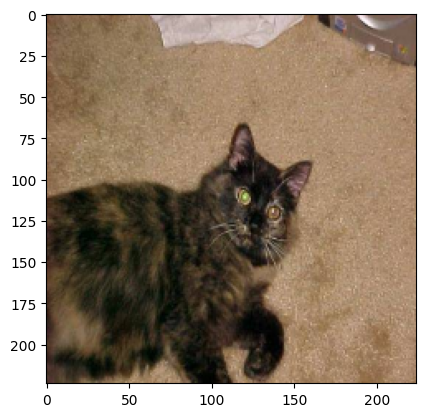

In [11]:
image1 = plt.imread('C:/Users/USER/Documents/data/catdog/test_set/cats/cat.4004.jpg')
image1 = tf.image.resize(image1/255, [img_height,img_width])
plt.imshow(image1)

Well, there is nothing more to doo with this dataset.

# Model processing

How can we deduce someone's age? Facial features, so GoogleNet can be an option, in addition, we can add ResNet architecture.

In [13]:
from tensorflow.keras import layers

Let's create a model and test it

In [13]:
class ResNeXtBlock(layers.Layer):
    def __init__(self, num_channels, groups, bot_mul, use_1x1conv=False, strides=1):
        super(ResNeXtBlock, self).__init__()
        bot_channels = int(round(num_channels * bot_mul))
        self.conv1 = layers.Conv2D(bot_channels, kernel_size=1, strides=1)
        self.conv2 = layers.Conv2D(bot_channels, kernel_size=3, strides=strides, padding='same', groups=bot_channels//groups)
        self.conv3 = layers.Conv2D(num_channels, kernel_size=1, strides=1)
        self.bn1 = layers.BatchNormalization()
        self.bn2 = layers.BatchNormalization()
        self.bn3 = layers.BatchNormalization()

        if use_1x1conv:
            self.conv4 = layers.Conv2D(num_channels, kernel_size=1, strides=strides)
            self.bn4 = layers.BatchNormalization()
        else:
            self.conv4 = None        

    def call(self, inp):
        x = self.conv1(inp)
        x = self.bn1(x)
        x = tf.nn.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = tf.nn.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        if self.conv4:
            x = self.bn4(self.conv4(x))
        x = x + inp
        out = tf.nn.relu(x)
        return out

In [14]:
class inception(tf.keras.layers.Layer):
    def __init__(self, filter1, filter3r, filter3, filter5r, filter5, maxPool):
        super().__init__()
        self.c1 = tf.keras.layers.Conv2D(filter1, (1, 1), padding='same', activation='relu')
        self.c2 = tf.keras.Sequential([
            tf.keras.layers.Conv2D(filter3r, (1, 1), padding='same', activation='relu'),
            tf.keras.layers.Conv2D(filter3, (1, 1), padding='same', activation='relu')
            ])
        self.c3 = tf.keras.Sequential([
            tf.keras.layers.Conv2D(filter5r, (1, 1), padding='same', activation='relu'),
            tf.keras.layers.Conv2D(filter5, (1, 1), padding='same', activation='relu')
            ])
        self.c4 = tf.keras.Sequential([
            tf.keras.layers.MaxPool2D((3, 3), strides=1, padding='same'),
            tf.keras.layers.Conv2D(maxPool, (1, 1), padding='same', activation='relu')
            ])
    
    def call(self, inp):
        out1 = self.c1(inp)
        out2 = self.c2(inp)
        out3 = self.c3(inp)
        out4 = self.c4(inp)
        return tf.concat([out1, out2, out3, out4], axis=3)

In [15]:
class Residual(layers.Layer):
    def __init__(self, num_channels, strides=1):
        super(Residual, self).__init__()
        self.conv1 = layers.Conv2D(num_channels, kernel_size=3, padding='same', strides=strides)
        self.conv2 = layers.Conv2D(num_channels, kernel_size=3, padding='same')
        self.bn1 = layers.BatchNormalization()
        self.bn2 = layers.BatchNormalization()

    def call(self, inp):
        x = self.conv1(inp)
        x = self.bn1(x)
        x = tf.nn.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = tf.nn.relu(x)
        if x.shape == inp.shape:
            x += inp
        return x

In [14]:
num_classes = len(class_names)

In [17]:
# ResNet
"""
parameters = [
    tf.keras.layers.Input(shape=(224, 224, 3)),
    tf.keras.layers.Conv2D(64, 7, strides=2, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(3, strides=2),
    Residual(64),
    Residual(64),
    Residual(128),
    Residual(128),
    Residual(256),
    Residual(256),
    Residual(512),
    Residual(512),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(10, activation='softmax')
]
"""
# LeNet
"""
parameters = [
    tf.keras.layers.Input(shape=(224, 224, 3)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding="same"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='softmax')
]
"""
# GoogLeNet
"""
parameters = [
    tf.keras.layers.Input(shape=(224, 224, 3)),
    tf.keras.layers.Conv2D(64, 7, strides=2, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(3, strides=2),
    tf.keras.layers.Conv2D(64, 1, strides=1, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(192, 3, strides=1, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(3, strides=2),
    inception(64, 96, 128, 16, 32, 32),
    inception(128, 128, 192, 32, 96, 64),
    tf.keras.layers.MaxPooling2D(3, strides= (2, 2)),
    inception(192, 96, 208, 16, 48, 64),
    inception(160, 112, 224, 24, 64, 64),
    inception(128, 128, 256, 24, 64, 64),
    inception(112, 144, 288, 32, 64, 64),
    inception(256, 160, 320, 32, 128, 128),
    tf.keras.layers.MaxPooling2D(3, strides=2),
    inception(256, 160, 320, 32, 128, 128),
    inception(384, 192, 384, 48, 128, 128),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(10, activation='softmax')
]
"""
# AlexNet
"""
parameters = [
    tf.keras.layers.Conv2D(filters=96, kernel_size=(11, 11), activation='relu', padding="same", input_shape=(img_width, img_height, 3)),
    tf.keras.layers.MaxPooling2D((3, 3), strides=2),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(5, 5), padding="same", activation='relu'),
    tf.keras.layers.MaxPooling2D((3, 3), strides=2),
    tf.keras.layers.Conv2D(filters=384, kernel_size=(3, 3), padding="same", activation='relu'),
    tf.keras.layers.Conv2D(filters=384, kernel_size=(3, 3), padding="same", activation='relu'),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation='relu'),
    tf.keras.layers.MaxPooling2D((3, 3), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='softmax')
]
"""

'\nparameters = [\n    tf.keras.layers.Conv2D(filters=96, kernel_size=(11, 11), activation=\'relu\', padding="same", input_shape=(img_width, img_height, 3)),\n    tf.keras.layers.MaxPooling2D((3, 3), strides=2),\n    tf.keras.layers.Conv2D(filters=256, kernel_size=(5, 5), padding="same", activation=\'relu\'),\n    tf.keras.layers.MaxPooling2D((3, 3), strides=2),\n    tf.keras.layers.Conv2D(filters=384, kernel_size=(3, 3), padding="same", activation=\'relu\'),\n    tf.keras.layers.Conv2D(filters=384, kernel_size=(3, 3), padding="same", activation=\'relu\'),\n    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation=\'relu\'),\n    tf.keras.layers.MaxPooling2D((3, 3), strides=2),\n    tf.keras.layers.Flatten(),\n    tf.keras.layers.Dense(4096, activation=\'relu\'),\n    tf.keras.layers.Dropout(0.5),\n    tf.keras.layers.Dense(4096, activation=\'relu\'),\n    tf.keras.layers.Dropout(0.5),\n    tf.keras.layers.Dense(2, activation=\'softmax\')\n]\n'

In [18]:
parameters = [
    tf.keras.layers.Input(shape=(224, 224, 3)),
    tf.keras.layers.Conv2D(64, 7, strides=2, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(3, strides=2),
    Residual(128),
    Residual(512),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='softmax')
]

In [19]:
model = tf.keras.Sequential(parameters)

In [20]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 64)      9472      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 55, 55, 64)       0         
 )                                                               
                                                                 
 residual (Residual)         (None, 55, 55, 128)       222464    
                                                                 
 residual_1 (Residual)       (None, 55, 55, 512)       2954240   
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               1

In [15]:
model = tf.keras.models.load_model('saved_model/my_model')

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint_filepath = 'best_model2'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True
)

In [27]:
model.fit(train_ds, epochs=10,  validation_data=val_ds, batch_size=16, callbacks=[model_checkpoint_callback, early_stopping_callback])

Epoch 1/10
5000/5000 [==============================] - ETA: 0s - loss: 0.2454 - accuracy: 0.8996

INFO:tensorflow:Assets written to: best_model2\assets


INFO:tensorflow:Assets written to: best_model2\assets


5000/5000 [==============================] - 420s 84ms/step - loss: 0.2454 - accuracy: 0.8996 - val_loss: 0.3106 - val_accuracy: 0.8838
Epoch 2/10
5000/5000 [==============================] - ETA: 0s - loss: 0.2361 - accuracy: 0.9038

INFO:tensorflow:Assets written to: best_model2\assets


INFO:tensorflow:Assets written to: best_model2\assets


5000/5000 [==============================] - 399s 80ms/step - loss: 0.2361 - accuracy: 0.9038 - val_loss: 0.2394 - val_accuracy: 0.9071
Epoch 3/10
5000/5000 [==============================] - ETA: 0s - loss: 0.2268 - accuracy: 0.9084

INFO:tensorflow:Assets written to: best_model2\assets


INFO:tensorflow:Assets written to: best_model2\assets


5000/5000 [==============================] - 412s 82ms/step - loss: 0.2268 - accuracy: 0.9084 - val_loss: 0.2140 - val_accuracy: 0.9105
Epoch 4/10
5000/5000 [==============================] - ETA: 0s - loss: 0.2189 - accuracy: 0.9113

INFO:tensorflow:Assets written to: best_model2\assets


INFO:tensorflow:Assets written to: best_model2\assets


5000/5000 [==============================] - 408s 82ms/step - loss: 0.2189 - accuracy: 0.9113 - val_loss: 0.1638 - val_accuracy: 0.9392
Epoch 5/10
5000/5000 [==============================] - 407s 81ms/step - loss: 0.2120 - accuracy: 0.9162 - val_loss: 0.2795 - val_accuracy: 0.8922
Epoch 6/10
5000/5000 [==============================] - 402s 80ms/step - loss: 0.2022 - accuracy: 0.9209 - val_loss: 0.2301 - val_accuracy: 0.8957
Epoch 7/10
5000/5000 [==============================] - 447s 89ms/step - loss: 0.1974 - accuracy: 0.9226 - val_loss: 0.1970 - val_accuracy: 0.9165
Epoch 8/10
5000/5000 [==============================] - 478s 96ms/step - loss: 0.1933 - accuracy: 0.9220 - val_loss: 0.2631 - val_accuracy: 0.8819


In [28]:
!mkdir saved_model
model.save('saved_model/my_model')

Ya existe el subdirectorio o el archivo saved_model.


INFO:tensorflow:Assets written to: saved_model/my_model\assets


INFO:tensorflow:Assets written to: saved_model/my_model\assets


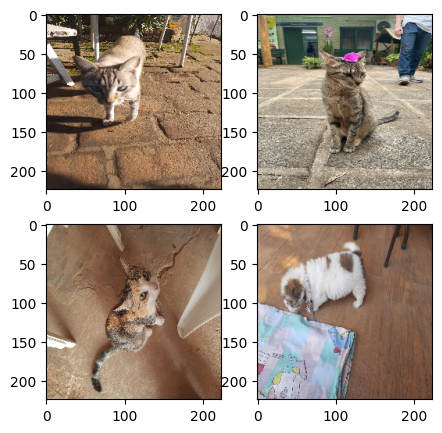

In [17]:
image1 = plt.imread('cat.jpg')/255
image1 = tf.image.resize(image1, [img_height,img_width])
image1 = tf.image.rot90(image1, k=3)
image2 = plt.imread('cat2.jpeg')/255
image2 = tf.image.resize(image2, [img_height,img_width])
image3 = plt.imread('cat3.jpg')/255
image3 = tf.image.resize(image3, [img_height,img_width])
image4 = plt.imread('dog.jpg')/255
image4 = tf.image.resize(image4, [img_height,img_width])
fig, ax = plt.subplots(2,2, figsize=(5,5))
ax[0,0].imshow(image1)
ax[0,1].imshow(image2)
ax[1,0].imshow(image3)
ax[1,1].imshow(image4)

In [28]:
image5 = plt.imread('cat4.jpeg')/255
image5 = tf.image.resize(image5, [img_height,img_width])
image6 = plt.imread('dog2.jpg')/255
image6 = tf.image.resize(image6, [img_height,img_width])
image7 = plt.imread('dog3.jpg')/255
image7 = tf.image.resize(image7, [img_height,img_width])
image8 = plt.imread('dog4.jpg')/255
image8 = tf.image.resize(image8, [img_height,img_width])

In [19]:
def mapping(input):
    if np.argmax(input) == 0:
        return "cat"
    else:
        return "dog"

In [29]:
mapping(model.predict(image8[tf.newaxis,...]))

1/1 [==============================] - 0s 23ms/step


'dog'

In [30]:
image_batch, labels_batch = next(iter(val_ds))

In [31]:
from sklearn.metrics import confusion_matrix, classification_report
predictions = np.argmax(model.predict(image_batch), axis=1)
cm = confusion_matrix(labels_batch, predictions)
clr = classification_report(labels_batch, predictions, zero_division=0)
print(clr)

1/1 [==============================] - 1s 1s/step
              precision    recall  f1-score   support

           0       1.00      0.93      0.97        15
           1       0.94      1.00      0.97        17

    accuracy                           0.97        32
   macro avg       0.97      0.97      0.97        32
weighted avg       0.97      0.97      0.97        32



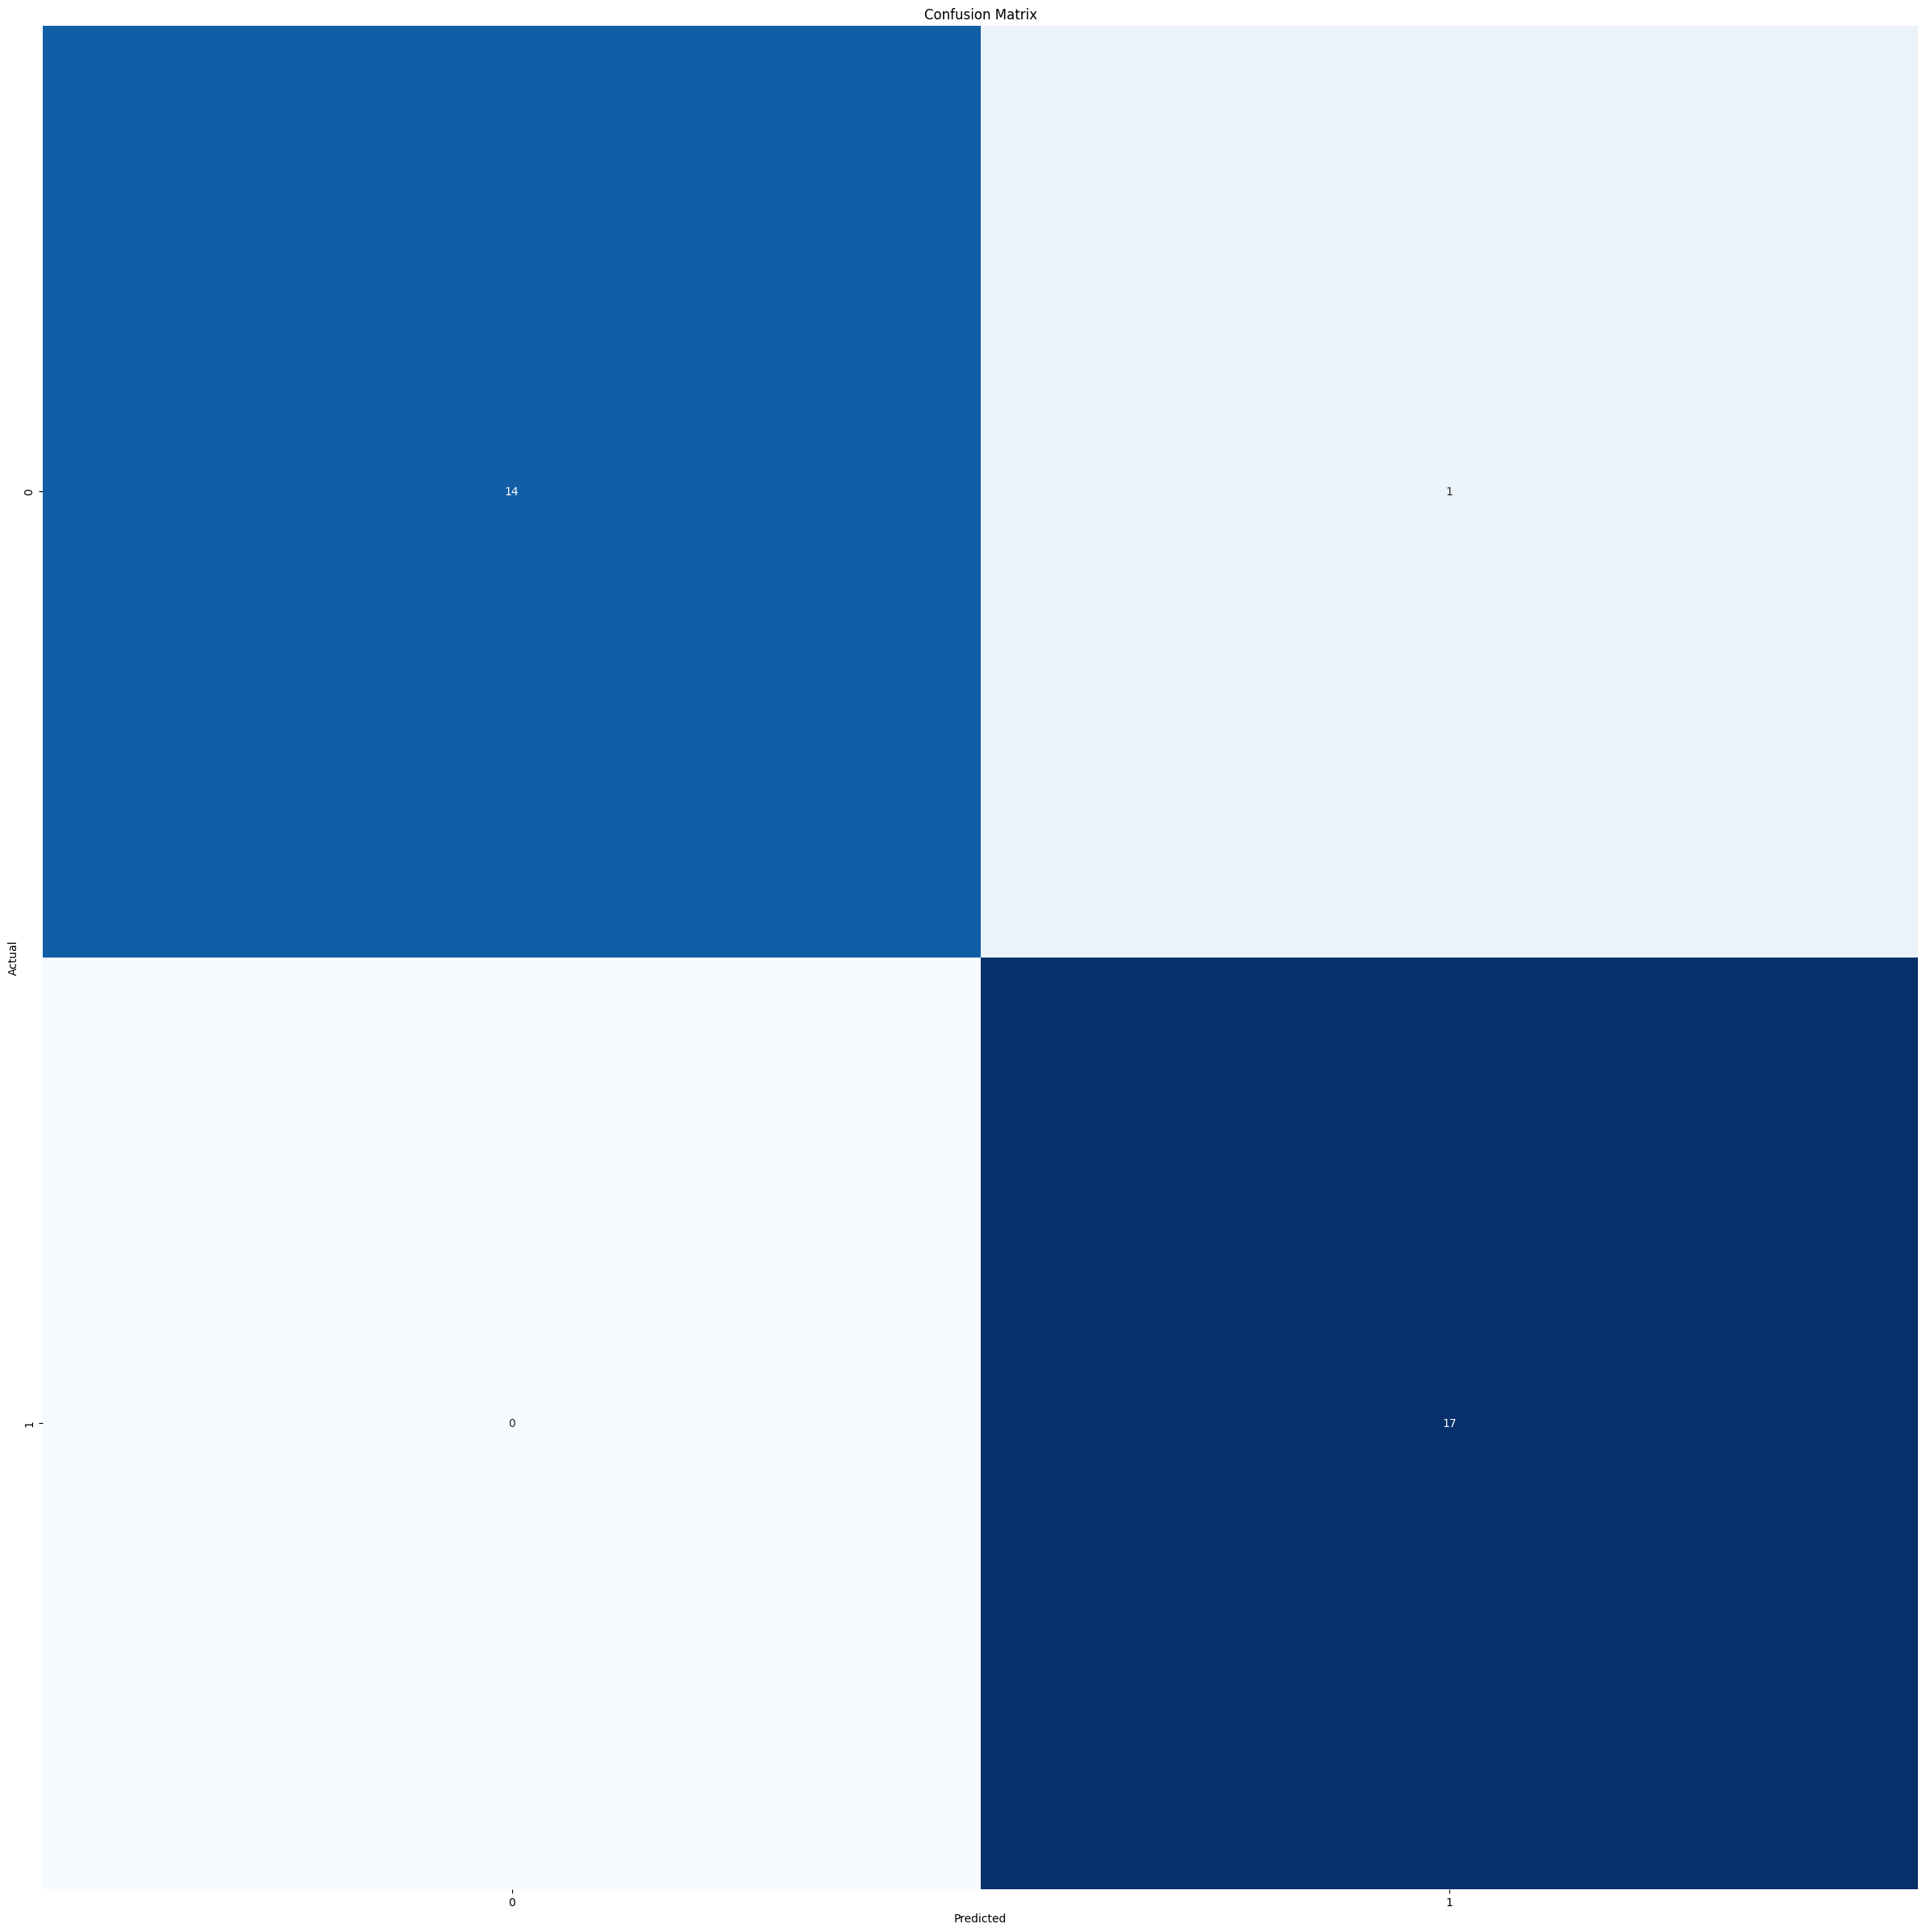

In [32]:
import seaborn as sns
plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()